In [1]:
import numpy as np
import matplotlib.pyplot as plt
from extrema_detection import find_potential_extrema, pwct, find_corrected_extrema
from onset_offset_detection import find_onsets, find_offsets
from metrics import (find_interbreath_interval,
    find_breathing_rate,
    find_volumes,
    find_tidal_volume,
    find_minute_ventilation,
    find_duty_cycle,
    find_coef_var_breathing_rate,
    find_coef_var_breath_volumes,
    find_coef_var_duty_cycle,
    )

from preprocess import mean_smooth, remove_global_drift, remove_local_drift, z_score
import pandas as pd

Extracting EDF parameters from /Users/rima/Desktop/breathmetrics-python/data/breaths/swiss398_ntx03_0.9dl50_streaming_1-1.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/rima/Desktop/breathmetrics-python/data/breaths/swiss400_ntx03_0.9dl50_streaming_1-1.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/rima/Desktop/breathmetrics-python/data/breaths/swiss401_nacl_streaming_1-1.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


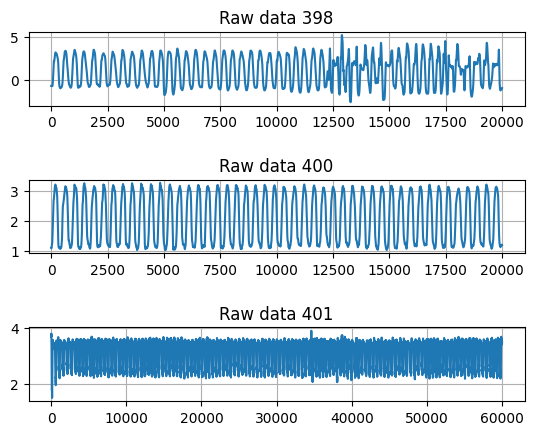

In [2]:
# Signals  extracted from the real data
import mne

fs = 200
file_398 = "./data/breaths/swiss398_ntx03_0.9dl50_streaming_1-1.EDF"
file_400 = "./data/breaths/swiss400_ntx03_0.9dl50_streaming_1-1.EDF"
file_401 = "./data/breaths/swiss401_nacl_streaming_1-1.EDF"

data_398 = mne.io.read_raw_edf(file_398)
data_400 = mne.io.read_raw_edf(file_400)
data_401 = mne.io.read_raw_edf(file_401)

# Data 
raw_data_398 = data_398.get_data()
raw_data_400 = data_400.get_data()
raw_data_401 = data_401.get_data()

# Signal used to perform the detection
y_398 = raw_data_398[0][:20000]
y_400 = raw_data_400[0][:20000]
y_401 = raw_data_401[0][:60000]

# Metadata 
info_398 = data_398.info 
channels_398 = data_398.ch_names
info_400 = data_400.info 
channels_400 = data_400.ch_names
info_401 = data_401.info 
channels_401 = data_401.ch_names

# Plot the data
figure, axis = plt.subplots(3, 1)

axis[0].plot(raw_data_398[0][:20000])
axis[0].set_title("Raw data 398")
axis[0].grid()

axis[1].plot(raw_data_400[0][:20000])
axis[1].set_title("Raw data 400")
axis[1].grid()

axis[2].plot(raw_data_401[0][:60000])
axis[2].set_title("Raw data 401")
axis[2].grid()

plt.subplots_adjust(hspace=1)

In [3]:
smoothed = mean_smooth(y_401, fs)
without_glob_drift = remove_global_drift(smoothed)
without_loc_glob_drift = remove_local_drift(without_glob_drift, fs, 60)
z = z_score(without_loc_glob_drift)
y_401_preprocessed = z

/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


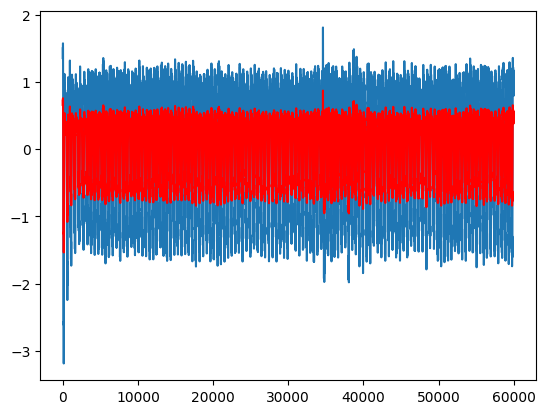

In [4]:
plt.plot(y_401_preprocessed)
plt.plot(without_loc_glob_drift, 'r')

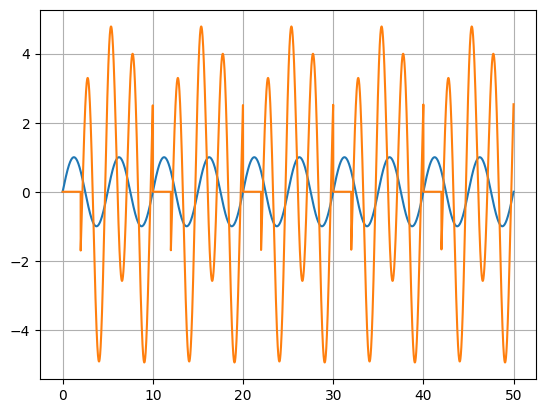

In [5]:
# Test with sinusoidal signal 
duration = 50
fs = 200
f = 0.2
x = np.linspace(0, duration, fs*duration)
y1 = np.sin(2*np.pi*f*x)
_ = plt.plot(x, y1)

# Signal generation with some pauses
y = np.sin(2*np.pi*f*x)+4*np.sin(2*2*np.pi*f*x+np.pi/4)-0.5*np.sin(np.pi*f*x+np.pi/5)

# Introduire des pauses en insérant des valeurs nulles dans le signal
pause_interval = 10  # intervalle entre chaque pause en secondes
pause_length = 2  # durée de chaque pause en secondes
pause_samples = int(pause_length*fs)  # nombre d'échantillons de chaque pause
for i in range(0, int(duration/pause_interval)):
    start_index = i*pause_interval*fs
    end_index = start_index + pause_samples
    y[start_index:end_index] = 0

_ = plt.plot(x, y)
plt.grid()

In [6]:
fs = 200

# Signal 398
peaks_398, troughs_398 = find_potential_extrema(y_398, fs)
peaks_idx_398, troughs_idx_398 = pwct(peaks_398, troughs_398)

# Signal 400
peaks_400, troughs_400 = find_potential_extrema(y_400, fs)
peaks_idx_400, troughs_idx_400 = pwct(peaks_400, troughs_400)

# Signal 401
peaks_401, troughs_401 = find_potential_extrema(y_401, fs)
peaks_idx_401, troughs_idx_401 = pwct(peaks_401, troughs_401)

# 401 Preprocessed
peaks_401_preprocessed, troughs_401_preprocessed = find_potential_extrema(y_401_preprocessed, fs)
peaks_idx_401_preprocessed, troughs_idx_401_preprocessed = pwct(peaks_401_preprocessed, troughs_401_preprocessed)

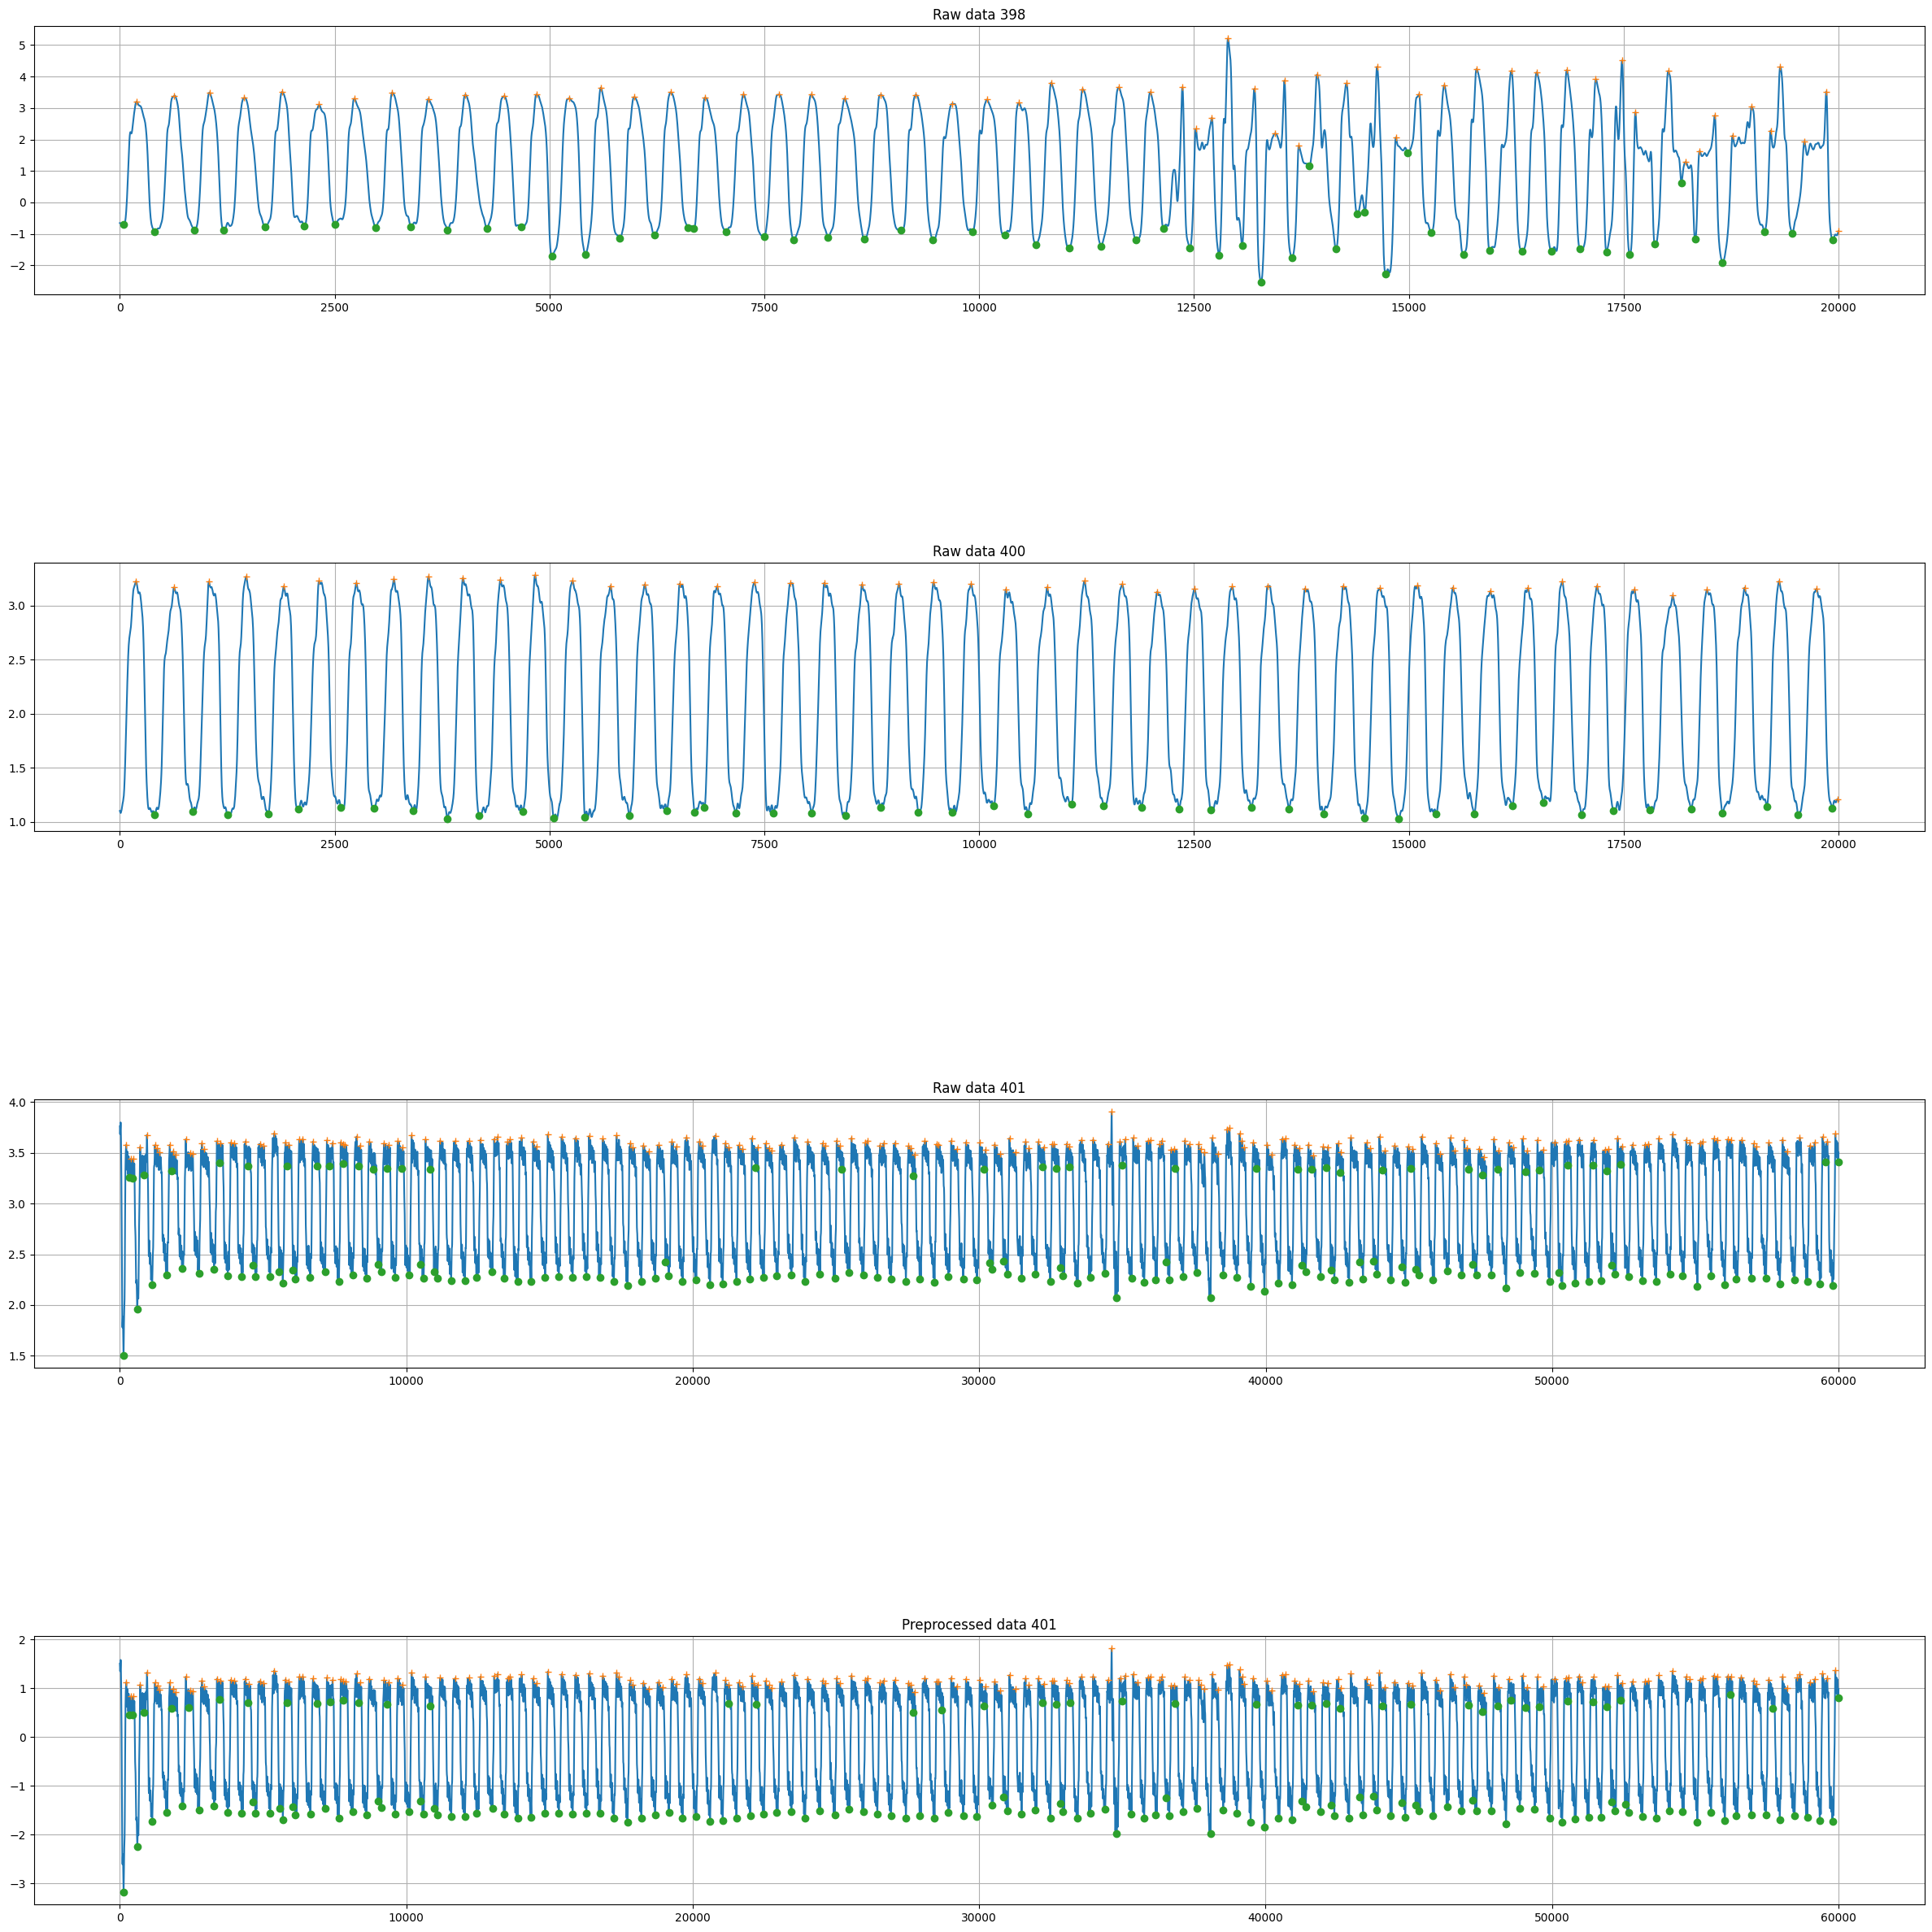

In [7]:
# Plotting the result
figure, axis = plt.subplots(4, 1, figsize=(30, 30))

_ = axis[0].plot(y_398)
axis[0].set_title("Raw data 398")
_ = axis[0].plot(peaks_idx_398, y_398[peaks_idx_398], '+')
_ = axis[0].plot(troughs_idx_398, y_398[troughs_idx_398], 'o')
axis[0].grid()

_ = axis[1].plot(y_400)
axis[1].set_title("Raw data 400")
_ = axis[1].plot(peaks_idx_400, y_400[peaks_idx_400], '+')
_ = axis[1].plot(troughs_idx_400, y_400[troughs_idx_400], 'o')
axis[1].grid()

_ = axis[2].plot(y_401)
axis[2].set_title("Raw data 401")
_ = axis[2].plot(peaks_idx_401, y_401[peaks_idx_401], '+')
_ = axis[2].plot(troughs_idx_401, y_401[troughs_idx_401], 'o')
axis[2].grid()

_ = axis[3].plot(y_401_preprocessed)
axis[3].set_title("Preprocessed data 401")
_ = axis[3].plot(peaks_idx_401_preprocessed, y_401_preprocessed[peaks_idx_401_preprocessed], '+')
_ = axis[3].plot(troughs_idx_401_preprocessed, y_401_preprocessed[troughs_idx_401_preprocessed], 'o')
axis[3].grid()



plt.subplots_adjust(hspace=1)
plt.show()

In [8]:
### Corrected_peaks and corrected_troughs

# Signal 398
corrected_peaks_398, corrected_troughs_398 = find_corrected_extrema(y_398, peaks_idx_398, troughs_idx_398)

# Signal 400
corrected_peaks_400, corrected_troughs_400 = find_corrected_extrema(y_400, peaks_idx_400, troughs_idx_400)

# Signal 401
corrected_peaks_401, corrected_troughs_401 = find_corrected_extrema(y_401, peaks_idx_401, troughs_idx_401)

# Preprocessed 401
corrected_peaks_401_preprocessed, corrected_troughs_401_preprocessed = \
    find_corrected_extrema(y_401_preprocessed, peaks_idx_401_preprocessed, troughs_idx_401_preprocessed)

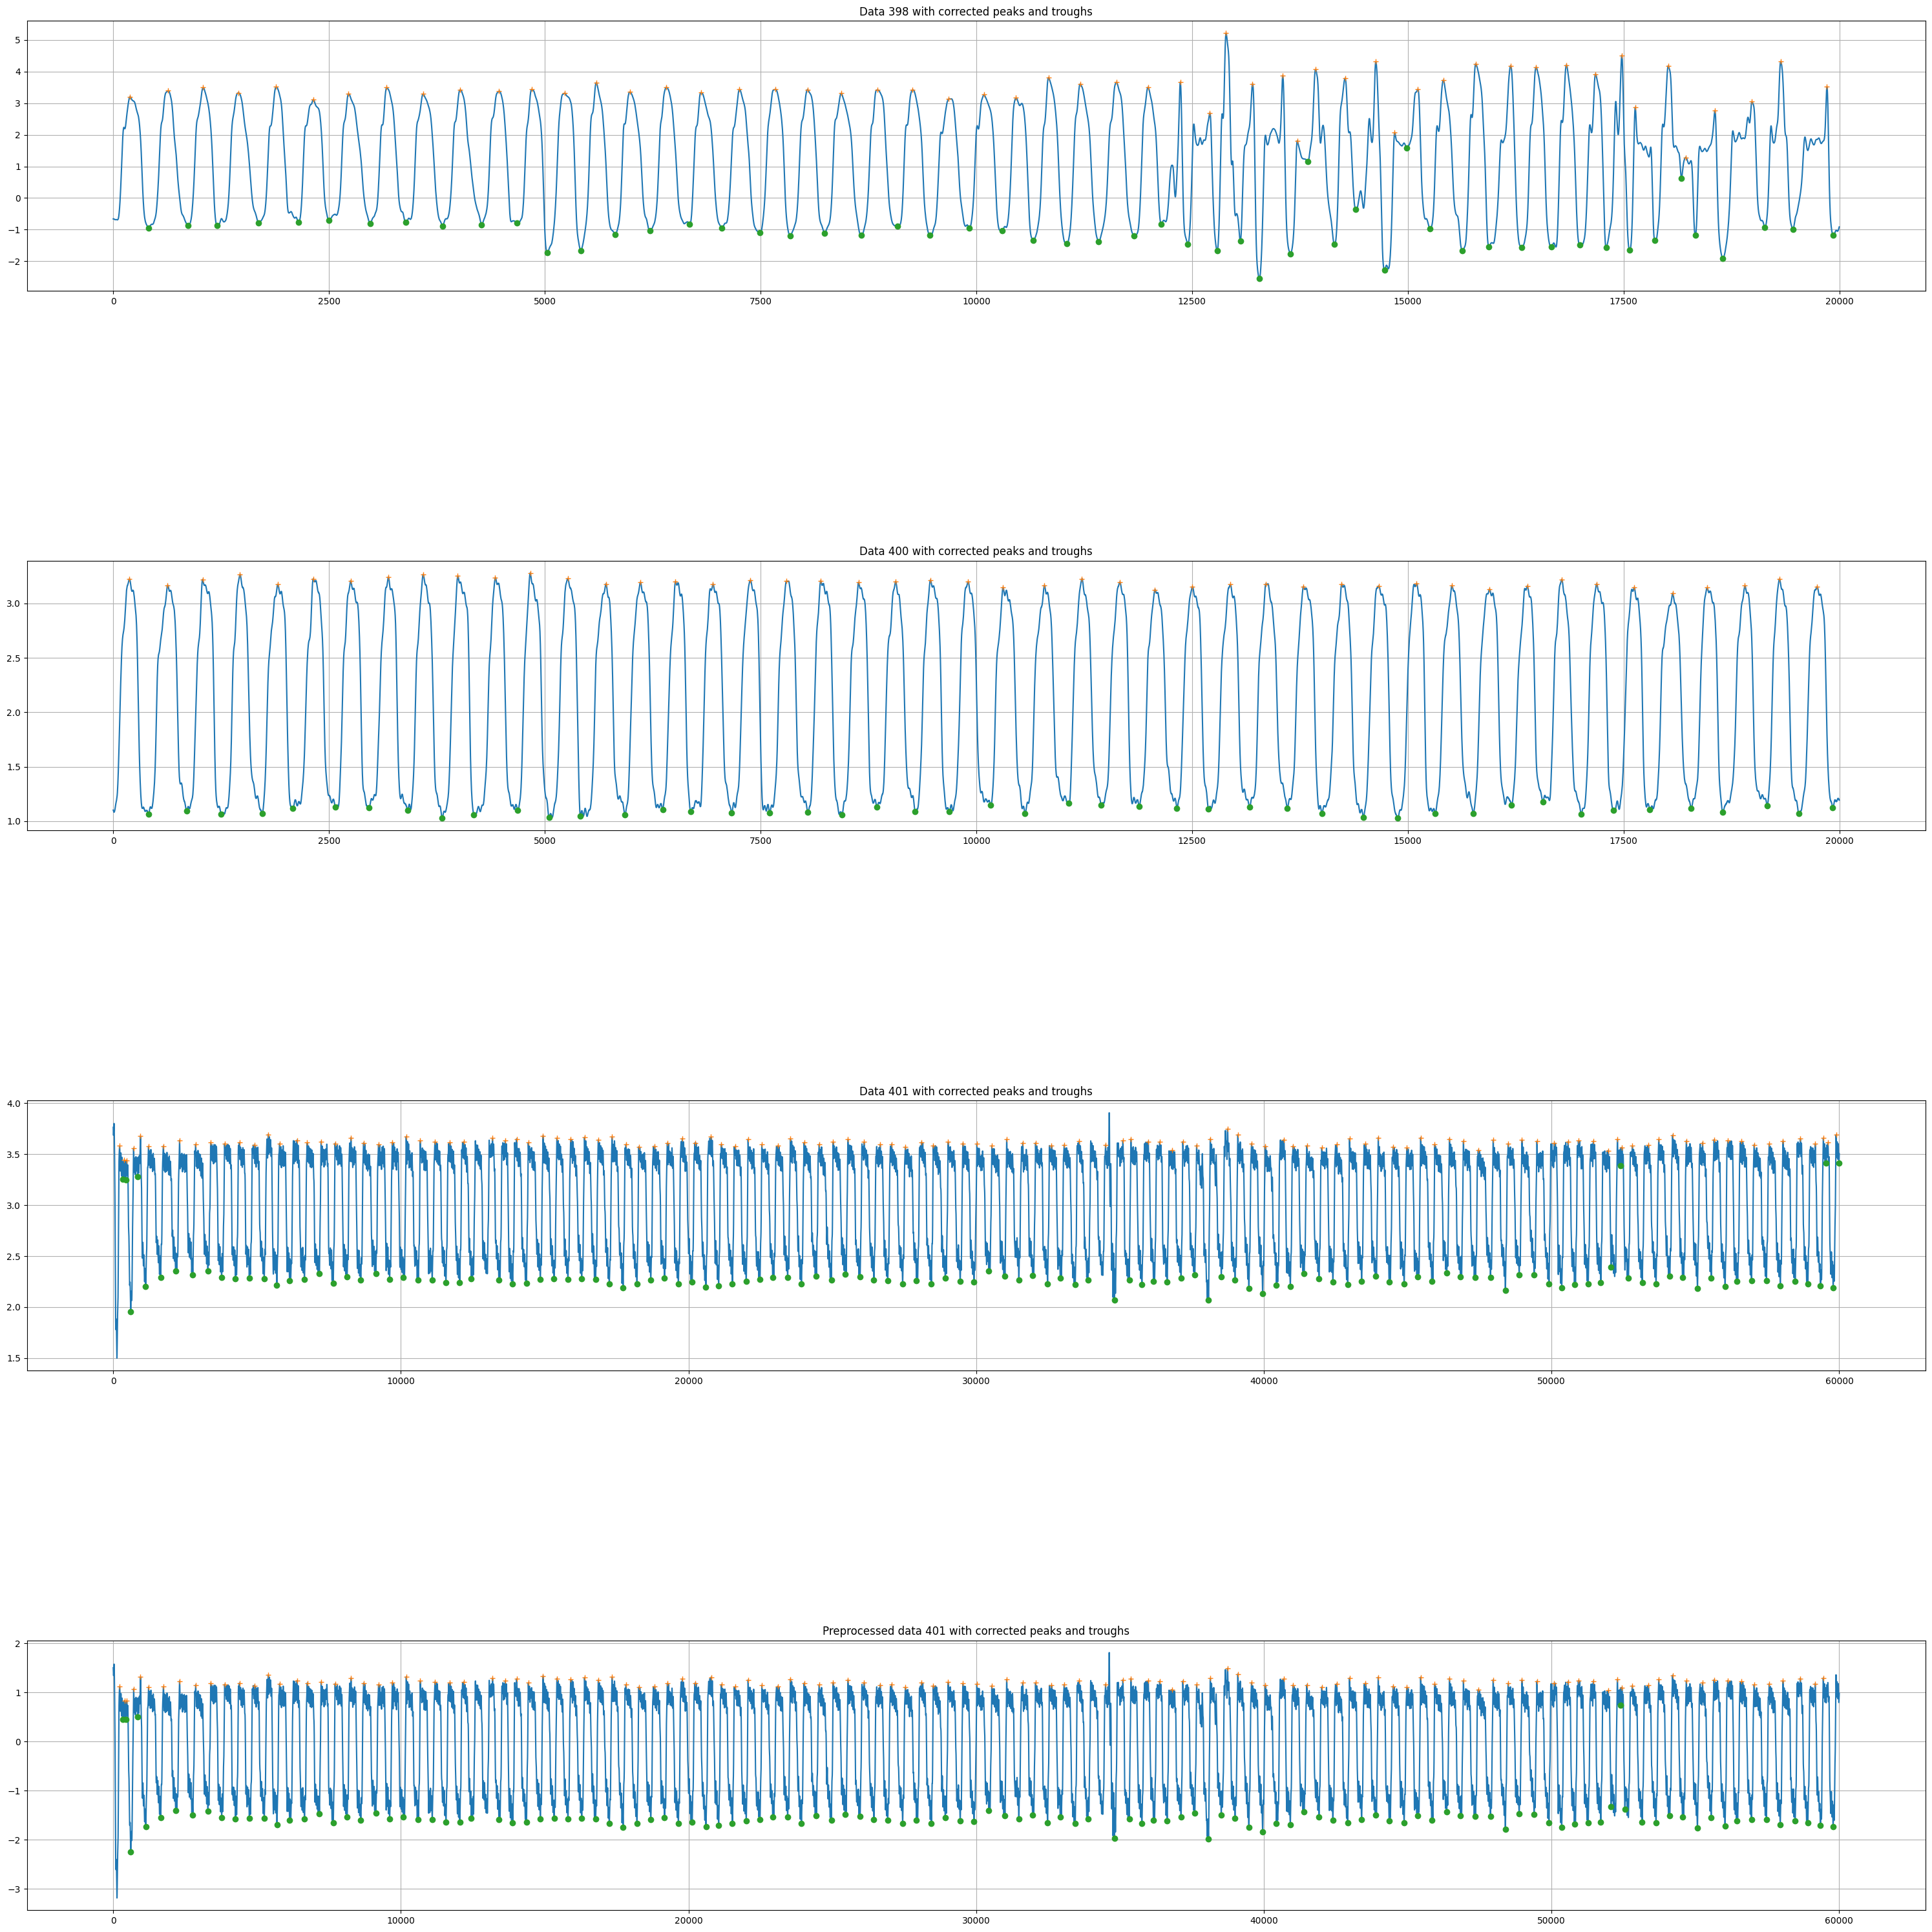

In [9]:
# Plotting the result
figure, axis = plt.subplots(4, 1, figsize=(30, 30))

# Signal 398
axis[0].plot(y_398)
axis[0].set_title("Data 398 with corrected peaks and troughs")
axis[0].plot(corrected_peaks_398, y_398[corrected_peaks_398], '+')
axis[0].plot(corrected_troughs_398, y_398[corrected_troughs_398], 'o')
axis[0].grid()

# Signal 400
axis[1].plot(y_400)
axis[1].set_title("Data 400 with corrected peaks and troughs")
axis[1].plot(corrected_peaks_400, y_400[corrected_peaks_400], '+')
axis[1].plot(corrected_troughs_400, y_400[corrected_troughs_400], 'o')
axis[1].grid()

# Signal 401
axis[2].plot(y_401)
axis[2].set_title("Data 401 with corrected peaks and troughs")
axis[2].plot(corrected_peaks_401, y_401[corrected_peaks_401], '+')
axis[2].plot(corrected_troughs_401, y_401[corrected_troughs_401], 'o')
axis[2].grid()

# Preprocessed 401
axis[3].plot(y_401_preprocessed)
axis[3].set_title("Preprocessed data 401 with corrected peaks and troughs")
axis[3].plot(corrected_peaks_401_preprocessed, y_401_preprocessed[corrected_peaks_401_preprocessed], '+')
axis[3].plot(corrected_troughs_401_preprocessed, y_401_preprocessed[corrected_troughs_401_preprocessed], 'o')
axis[3].grid()

plt.tight_layout()
plt.subplots_adjust(hspace=1)
plt.show()

Shape of peaks_idx_398 :  (62,)
Shape of troughs_idx_398 :  (58,)
Shape of y_398 :  (20000,)
Shape of corrected_peaks_398 :  (55,)
Shape of corrected_troughs_398 :  (55,)
Shape of peaks_idx :  (20,)
Shape of troughs_idx :  (20,)
Shape of y :  (10000,)
Shape of corrected_peaks :  (19,)
Shape of corrected_troughs :  (19,)


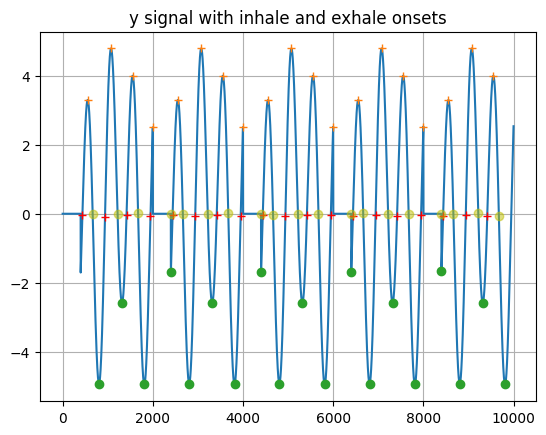

In [10]:
## Debug find_onsets
# Checking of shape 
print('Shape of peaks_idx_398 : ', np.shape(peaks_idx_398))
print('Shape of troughs_idx_398 : ', np.shape(troughs_idx_398))
print('Shape of y_398 : ', np.shape(y_398))
print('Shape of corrected_peaks_398 : ', np.shape(corrected_peaks_398))
print('Shape of corrected_troughs_398 : ', np.shape(corrected_troughs_398))

## Test on y signal 
peaks, troughs = find_potential_extrema(y, fs)
peaks_idx, troughs_idx = pwct(peaks, troughs)
corrected_peaks, corrected_troughs = find_corrected_extrema(y, peaks_idx, troughs_idx)
inhale_onsets, exhale_onsets, inhale_pause_onsets, exhale_pause_onsets = find_onsets(y, np.array(corrected_peaks), np.array(corrected_troughs))

# Checking shape
print('Shape of peaks_idx : ', np.shape(peaks_idx))
print('Shape of troughs_idx : ', np.shape(troughs_idx))
print('Shape of y : ', np.shape(y))
print('Shape of corrected_peaks : ', np.shape(corrected_peaks))
print('Shape of corrected_troughs : ', np.shape(corrected_troughs))

# Plot the y signal
plt.plot(y)
plt.title("y signal with inhale and exhale onsets")
plt.plot(inhale_onsets, y[inhale_onsets], 'r+')
plt.plot(exhale_onsets, y[exhale_onsets], 'yo', alpha = .5)
plt.plot(corrected_peaks, y[corrected_peaks], '+')
plt.plot(corrected_troughs, y[corrected_troughs], 'o')
plt.grid()

In [11]:
# Signal 398
inhale_onsets_398, exhale_onsets_398, inhale_pause_onsets_398, exhale_pause_onsets_398 = find_onsets(y_398, np.array(corrected_peaks_398), np.array(corrected_troughs_398))


# Signal 400
inhale_onsets_400, exhale_onsets_400, inhale_pause_onsets_400, exhale_pause_onsets_400 = find_onsets(y_400, np.array(corrected_peaks_400), np.array(corrected_troughs_400))

# Signal 401
inhale_onsets_401, exhale_onsets_401, inhale_pause_onsets_401, exhale_pause_onsets_401 = find_onsets(y_401, np.array(corrected_peaks_401), np.array(corrected_troughs_401))

# Preprocessed 401
inhale_onsets_401_preprocessed, exhale_onsets_401_preprocessed, inhale_pause_onsets_401_preprocessed, exhale_pause_onsets_preprocessed \
    = find_onsets(y_401_preprocessed, np.array(corrected_peaks_401_preprocessed), np.array(corrected_troughs_401_preprocessed))

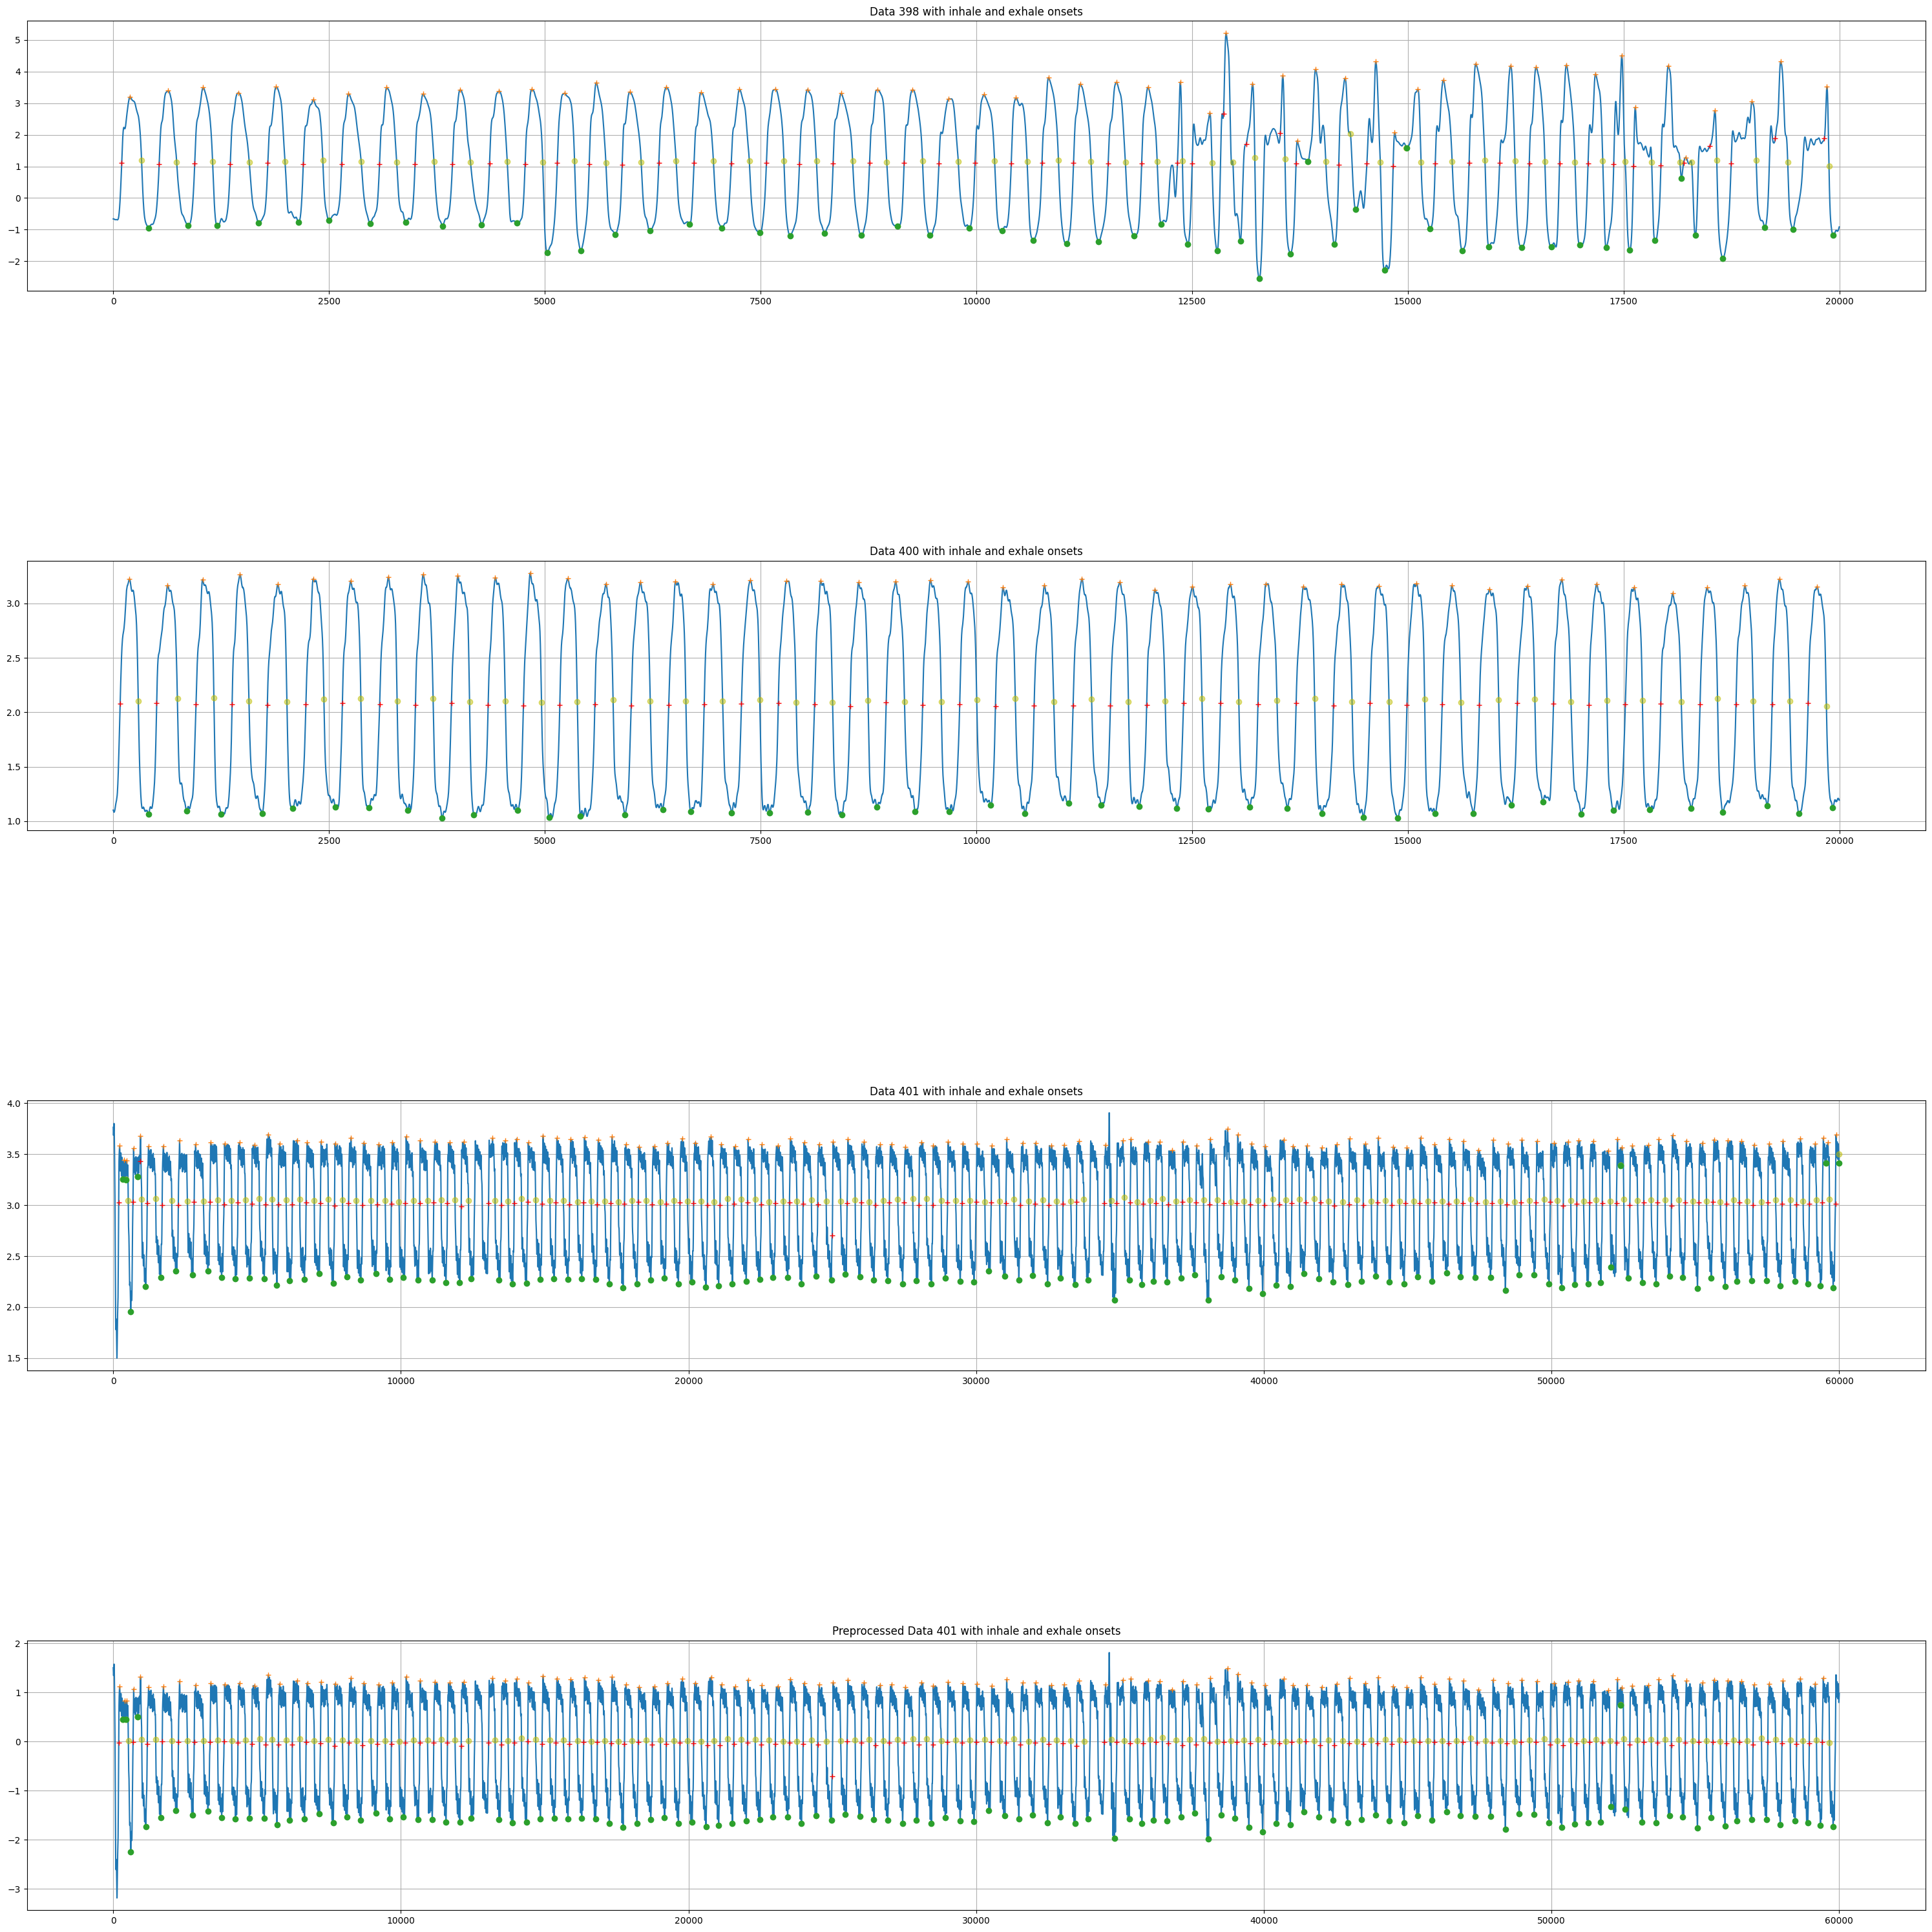

In [12]:
# Plotting the result
figure, axis = plt.subplots(4, 1, figsize=(30, 30))

# Signal 398
axis[0].plot(y_398)
axis[0].set_title("Data 398 with inhale and exhale onsets")
axis[0].plot(inhale_onsets_398, y_398[inhale_onsets_398], 'r+')
axis[0].plot(exhale_onsets_398, y_398[exhale_onsets_398], 'yo', alpha = .5)
axis[0].plot(corrected_peaks_398, y_398[corrected_peaks_398], '+')
axis[0].plot(corrected_troughs_398, y_398[corrected_troughs_398], 'o')
axis[0].grid()

# Signal 400
axis[1].plot(y_400)
axis[1].set_title("Data 400 with inhale and exhale onsets")
axis[1].plot(inhale_onsets_400, y_400[inhale_onsets_400], 'r+')
axis[1].plot(exhale_onsets_400, y_400[exhale_onsets_400], 'yo', alpha = .5)
axis[1].plot(corrected_peaks_400, y_400[corrected_peaks_400], '+')
axis[1].plot(corrected_troughs_400, y_400[corrected_troughs_400], 'o')
axis[1].grid()

# Signal 401
axis[2].plot(y_401)
axis[2].set_title("Data 401 with inhale and exhale onsets")
axis[2].plot(inhale_onsets_401, y_401[inhale_onsets_401], 'r+')
axis[2].plot(exhale_onsets_401, y_401[exhale_onsets_401], 'yo', alpha = .5)
axis[2].plot(corrected_peaks_401, y_401[corrected_peaks_401], '+')
axis[2].plot(corrected_troughs_401, y_401[corrected_troughs_401], 'o')
axis[2].grid()

# Preprocessed  401
axis[3].plot(y_401_preprocessed)
axis[3].set_title("Preprocessed Data 401 with inhale and exhale onsets")
axis[3].plot(inhale_onsets_401_preprocessed, y_401_preprocessed[inhale_onsets_401_preprocessed], 'r+')
axis[3].plot(exhale_onsets_401_preprocessed, y_401_preprocessed[exhale_onsets_401_preprocessed], 'yo', alpha = .5)
axis[3].plot(corrected_peaks_401_preprocessed, y_401_preprocessed[corrected_peaks_401_preprocessed], '+')
axis[3].plot(corrected_troughs_401_preprocessed, y_401_preprocessed[corrected_troughs_401_preprocessed], 'o')
axis[3].grid()

plt.tight_layout()
plt.subplots_adjust(hspace=1)
plt.show()

In [12]:
inhale_onsets

array([ 438,  939, 1417, 1947, 2438, 2939, 3417, 3947, 4438, 4939, 5417,
       5947, 6437, 6939, 7416, 7947, 8437, 8939, 9416])

In [13]:
samples_between_inhale_onsets = [inhale_onsets[i + 1] - inhale_onsets[i] for i in range(len(inhale_onsets) - 1)]
(np.array(samples_between_inhale_onsets) / fs).mean()

2.4938888888888884

In [14]:
interbreath_interval = find_interbreath_interval(fs, inhale_onsets)
interbreath_interval

2.4938888888888884

In [15]:
breathing_rate = find_breathing_rate(fs, inhale_onsets)
breathing_rate

0.4009801737580754

In [16]:
find_coef_var_breathing_rate(fs, inhale_onsets)

0.03814909275283999

In [17]:
1 / breathing_rate

2.4938888888888884

In [18]:
inhale_offsets, exhale_offsets = find_offsets(y, inhale_onsets, exhale_onsets, inhale_pause_onsets, exhale_pause_onsets)

In [19]:
inhale_volumes, exhale_volumes = find_volumes(y, fs, inhale_onsets, inhale_offsets, exhale_onsets, exhale_offsets )

In [20]:
inhale_volumes

array([2398.05519969, 4165.28710543, 3231.76203174,  339.25146862,
       2398.02848627, 4165.18691086, 3231.73268913,  341.67065152,
       2398.00019954, 4165.06618021, 3231.73975173,  344.16994744,
       2398.19696184, 4165.02809824, 3232.05394807,  346.6664845 ,
       2398.13559563, 4164.90075404, 3232.07102207])

In [21]:
find_coef_var_breath_volumes(inhale_volumes)

0.5105692686569702

In [22]:
tidal_volume = find_tidal_volume(inhale_volumes, exhale_volumes)
tidal_volume

5375.881544710664

In [23]:
find_minute_ventilation(breathing_rate, tidal_volume)

129337.31495405475

In [24]:
find_duty_cycle(fs, inhale_onsets, inhale_offsets, interbreath_interval)

0.5910236718997316

In [25]:
find_coef_var_duty_cycle(fs, inhale_onsets, inhale_offsets)

0.2804729556319838

In [26]:
exhale_offsets

array([ 938., 1416., 1946., 2437., 2938., 3416., 3946., 4437., 4938.,
       5416., 5946., 6436., 6938., 7415., 7946., 8436., 8938., 9415.,
       9947.])

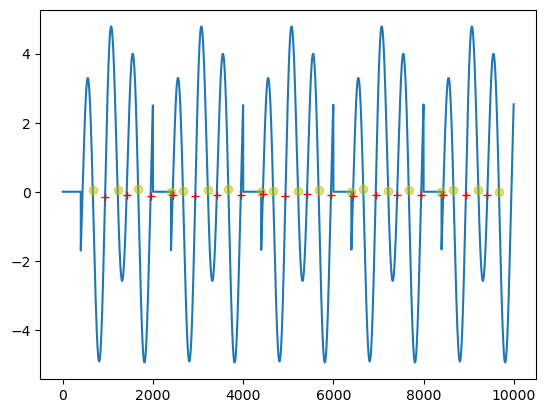

In [27]:
_ = plt.plot(y)
_ = plt.plot(inhale_offsets, y[inhale_offsets.astype(int)], 'yo', alpha = .5)
_ = plt.plot(exhale_offsets[:-1], y[exhale_offsets[:-1].astype(int)], 'r+')

In [28]:
def plot_corrected_vs_potential(signal, 
        potential_peaks, potential_troughs, \
        corrected_peaks, corrected_troughs):
    _ = plt.plot(signal, 'k', alpha = .1, label = 'signal')
    _ = plt.scatter(corrected_peaks, signal[corrected_peaks], marker=8, c='y', label='corrected peaks')
    _ = plt.scatter(corrected_troughs, signal[corrected_troughs], marker=10, c='y', label='corrected troughs')
    _ = plt.scatter(potential_peaks, signal[potential_peaks], marker=9, c='r', label='potential peaks')
    _ = plt.scatter(potential_troughs, signal[potential_troughs], marker=11, c='r', label='potential troughs')
    _ = plt.legend()

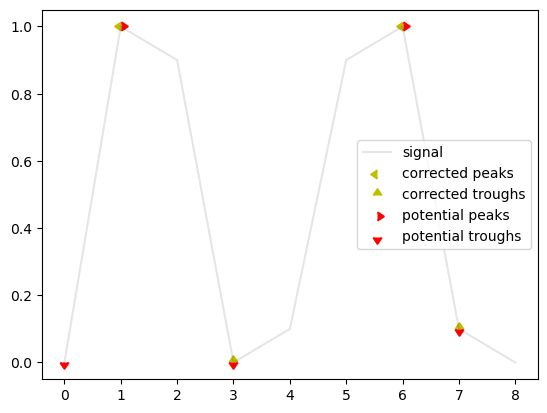

In [29]:
start_with_peak = np.array([0, 1, .9, 0, .1, .9, 1, .1, 0])
potential_peaks = [1, 6]
potential_troughs = [0, 3, 7]
corrected_peaks, corrected_troughs = find_corrected_extrema(start_with_peak, potential_peaks, potential_troughs)
plot_corrected_vs_potential(start_with_peak, potential_peaks, potential_troughs, corrected_peaks, corrected_troughs)

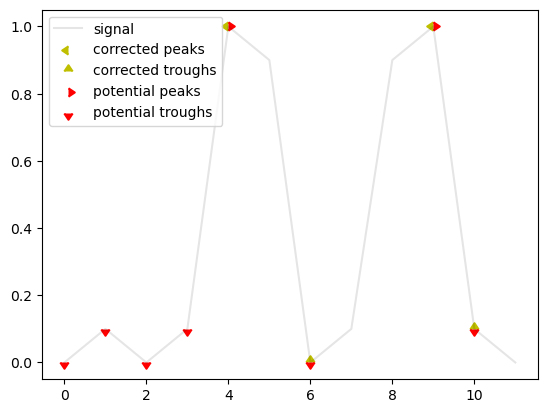

In [30]:
start_with_peak = np.array([0,.1, 0, .1, 1, .9, 0, .1, .9, 1, .1, 0])
potential_peaks = [4, 9]
potential_troughs = [0, 1, 2, 3, 6, 10]
corrected_peaks, corrected_troughs = find_corrected_extrema(start_with_peak, potential_peaks, potential_troughs)
plot_corrected_vs_potential(start_with_peak, potential_peaks, potential_troughs, corrected_peaks, corrected_troughs)

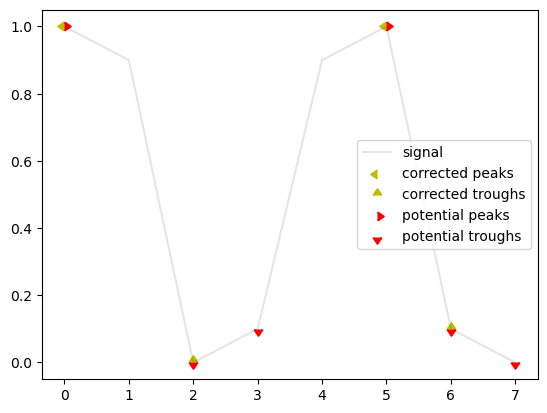

In [31]:
remove_trough = np.array([1, .9, 0, .1, .9, 1, .1, 0])
potential_peaks = [0, 5]
potential_troughs = [2, 3, 6, 7]
corrected_peaks, corrected_troughs = find_corrected_extrema(remove_trough, potential_peaks, potential_troughs)
plot_corrected_vs_potential(remove_trough, potential_peaks, potential_troughs, corrected_peaks, corrected_troughs)

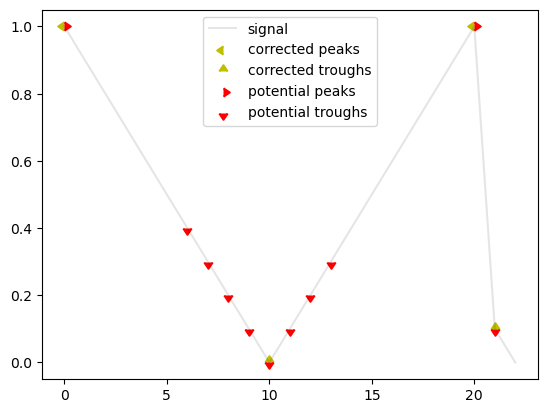

In [32]:
remove_trough = np.array([1, .9, .8, .7, .6, .5, .4, .3, .2, .1, 0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, .1, 0])
potential_peaks = [0, 20]
potential_troughs = [6, 7, 8, 9, 10, 11, 12, 13, 21]
corrected_peaks, corrected_troughs = find_corrected_extrema(remove_trough, potential_peaks, potential_troughs)
plot_corrected_vs_potential(remove_trough, potential_peaks, potential_troughs, corrected_peaks, corrected_troughs)

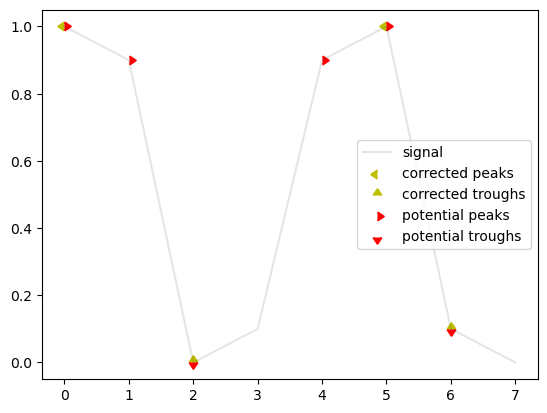

In [33]:
remove_peak = np.array([1, .9, 0, .1, .9, 1, .1, 0])
potential_peaks = [0, 1, 4, 5]
potential_troughs = [2, 6]
corrected_peaks, corrected_troughs = find_corrected_extrema(remove_peak, potential_peaks, potential_troughs)
plot_corrected_vs_potential(remove_peak, potential_peaks, potential_troughs, corrected_peaks, corrected_troughs)

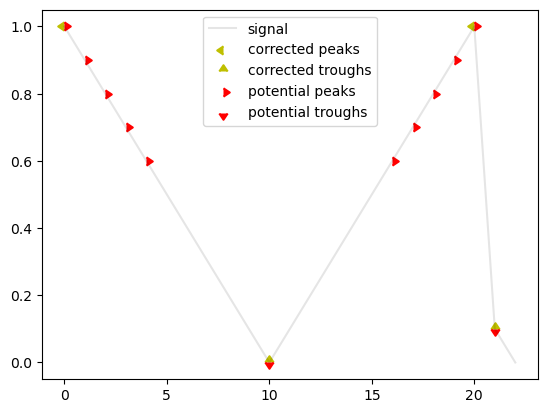

In [34]:
remove_peaks = np.array([1, .9, .8, .7, .6, .5, .4, .3, .2, .1, 0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, .1, 0])
potential_peaks = [0, 1, 2, 3, 4, 16, 17, 18, 19, 20]
potential_troughs = [10, 21]
corrected_peaks, corrected_troughs = find_corrected_extrema(remove_peaks, potential_peaks, potential_troughs)
plot_corrected_vs_potential(remove_peaks, potential_peaks, potential_troughs, corrected_peaks, corrected_troughs)

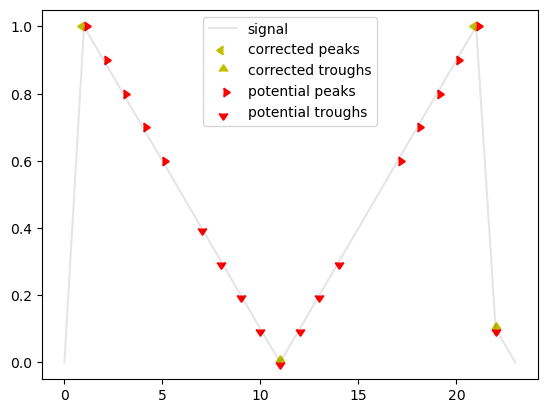

In [35]:
remove_everything = np.array([0, 1, .9, .8, .7, .6, .5, .4, .3, .2, .1, 0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, .1, 0])
potential_peaks = [1,  2,  3,  4,  5, 17, 18, 19, 20, 21]
potential_troughs = [7,  8,  9, 10, 11, 12, 13, 14, 22]
corrected_peaks, corrected_troughs = find_corrected_extrema(remove_everything, potential_peaks, potential_troughs)
plot_corrected_vs_potential(remove_everything, potential_peaks, potential_troughs, corrected_peaks, corrected_troughs)

In [36]:
!python -m unittest

...............
----------------------------------------------------------------------
Ran 15 tests in 0.004s

OK


In [37]:
#!pip install --upgrade numpy==1.21.6

In [38]:
#!pipreqs . --force

In [39]:
!pip install pylint

In [40]:
!pip install 'pylint[spelling]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 1.3 MB/s eta 0:00:00


In [41]:
!pylint ./extrema_detection/_findExtrema.py

************* Module /Users/MelaniePietri/Documents/MVA/Séries Temporelles/breathmetrics-python-main/.pylintrc
.pylintrc:1:0: E0015: Unrecognized option found: module-name-hint, command (unrecognized-option)
************* Module breathmetrics-python-main.extrema_detection._findExtrema
extrema_detection/_findExtrema.py:1:0: C0114: Missing module docstring (missing-module-docstring)
extrema_detection/_findExtrema.py:8:0: C0116: Missing function or method docstring (missing-function-docstring)
extrema_detection/_findExtrema.py:35:0: C0116: Missing function or method docstring (missing-function-docstring)
extrema_detection/_findExtrema.py:55:0: C0116: Missing function or method docstring (missing-function-docstring)
extrema_detection/_findExtrema.py:76:0: C0116: Missing function or method docstring (missing-function-docstring)

-----------------------------------
Your code has been rated at 9.38/10



In [42]:
!black .

Skipping .ipynb files as Jupyter dependencies are not installed.
You can fix this by running ``pip install black[jupyter]``
reformatted demo.py

All done! ✨ 🍰 ✨
1 file reformatted, 11 files left unchanged.


In [43]:
!pylint .

************* Module /Users/MelaniePietri/Documents/MVA/Séries Temporelles/breathmetrics-python-main/.pylintrc
.pylintrc:1:0: E0015: Unrecognized option found: module-name-hint, command (unrecognized-option)
************* Module breathmetrics-python-main
__init__.py:1:0: C0103: Module name "breathmetrics-python-main" doesn't conform to '(([a-z_][A-Za-z0-9_]*)|([A-Z][a-zA-Z0-9]+))$' pattern (invalid-name)


In [44]:
pip install pre-commit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.7/202.7 kB 1.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 2.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 1.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 1.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
